In [392]:
# ! pip install causalml

## Interpretation

To summarize:


The dataset contains data on a government transfer program that was administered based on an income cutoff.

Data is limited to households hovering around the income cutoff.

The dataset contains 1,948 observations with 5 variables.

The variables in the dataset include:
- Income_Centered: Measure of income, centered around the program cutoff. Negative values indicate Eligibility.
- Education: Household average years of education among those 16 +
- Age: Household Average Age
- Participation: Participation in the Government Transfers Program
- Support: Measure of Support for the Government

Approach followed:

**Hypothesis being studied: Do welfare programs targeting the needy translate into more votes (broadly, support for the government) ?**

The following is my identification of the target, control and treatment features:
- TARGET (OUTCOME VARIABLE): Measure of Support for the Government.
- CONTROL FEATURES: Income_Centered, Education, Age
- TREATMENT FEATURES - Participation


## Interpretation of Results

The average treatment effect of 0.0975 means that,on average, participating in the Government's Transfers program increases the Support by 0.0975 units across the entire population, irrespective of whether they were initially in the treatment or control group. 


The ATC (Average Treatment Effect on the Control Group) of 0.105 means that, on average, the control group would experience an increase of 0.105 units in Support for the Government if they participated in the Transfers program offered by the government.

**This happens to be in alignment with the hypothesis that welfare programs targeting the needy could translate into increased support for the government**

### Feature Importance

Feature importance was studied using two kinds of regressors:

- the XGBT Regressor
- the LRS Regressor

Upon studying feature importance using the XGBT Regressor, it was found that:
- Age is the most important feature from the point of view of causal inference, followed by income and finally, education.

This makes sense considering people who are either very young or very old are in positions where government handouts can really help, and thereby increase their support for the government. On the other hand, educated people are less likely to fall for such things or be in a position to receive government handouts to begin with.

Studying feature importance using the LRS Regressor, similar results were unable to be replicated. However, it did yield the value of the Average Treatment Effect on the Control Group, equalling 0.0975.


In [ ]:
import os, sys
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # for lightgbm to work

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.metrics.visualize import plot_gain
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12, 8)


In [394]:
plt.style.use('fivethirtyeight')

Uploading the dataset.

The dataset used studies Government Transfers and Political Support.

Source: American Economic Journal: Applied Economics, 3(3), pp.1-28.


The dataset contains data on a government transfer program that was administered based on an income cutoff.

Data is limited to households hovering around the income cutoff.

In [395]:
data_root: str = "https://github.com/NickCH-K/causaldata/tree/main/"

In [396]:
gov_data = pd.read_csv("https://raw.githubusercontent.com/NickCH-K/causaldata/main/Python/causaldata/gov_transfers/Government_Transfers_RDD_Data.csv")

In [397]:
gov_data.head(5)

,Income_Centered,Education,Age,Participation,Support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0


In [398]:
gov_data.dtypes

Income_Centered    float64
Education          float64
Age                float64
Participation        int64
Support            float64
dtype: object

About the dataset:

The dataset contains 1,948 observations with 5 variables.

The variables in the dataset include:
- Income_Centered: Measure of income, centered around the program cutoff. Negative values indicate Eligibility.
- Education: Household average years of education among those 16 +
- Age: Household Average Age
- Participation: Participation in the Government Transfers Program
- Support: Measure of Support for the Government

Approach followed:

**Hypothesis being studied: Do welfare programs targeting the needy translate into more votes (broadly, support for the government) ?**

The following is my identification of the target, control and treatment features:
- TARGET (OUTCOME VARIABLE): Measure of Support for the Government.
- CONTROL FEATURES: Income_Centered, Education, Age
- TREATMENT FEATURES - Participation

In [399]:
gov_data['Participation'].value_counts()

1    1127
0     821
Name: Participation, dtype: int64

In [400]:
gov_data.head(5)

,Income_Centered,Education,Age,Participation,Support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0


In [401]:
gov_data['Group_Key'] = gov_data.apply(lambda row: "Control" if row['Participation'] == 0 else "Treatment", axis = 1)

In [402]:
gov_data.head(5)

,Income_Centered,Education,Age,Participation,Support,Group_Key
0,0.006571,3.5,23.666666,0,1.0,Control
1,0.011075,1.5,42.000000,0,1.0,Control
2,0.002424,4.0,43.000000,0,1.0,Control
3,0.007650,6.0,21.000000,0,0.5,Control
4,0.010001,2.0,33.000000,0,1.0,Control


In [403]:
# Summary level description of the data

gov_data.describe()

,Income_Centered,Education,Age,Participation,Support
count,1948.000000,1897.000000,1948.000000,1948.000000,1948.000000
mean,-0.001580,4.070623,29.124287,0.578542,0.796201
std,0.011631,1.530783,14.428391,0.493919,0.318164
min,-0.019991,0.000000,6.500000,0.000000,0.000000
25%,-0.011714,3.000000,18.383333,0.000000,0.500000
50%,-0.002796,4.000000,25.666666,1.000000,1.000000
75%,0.008447,5.500000,36.000000,1.000000,1.000000
max,0.019892,6.500000,73.000000,1.000000,1.000000


In [404]:
# Check for missing values by column

missing_counts = gov_data.isna().sum()

In [405]:
missing_counts.sort_values()

Income_Centered     0
Age                 0
Participation       0
Support             0
Group_Key           0
Education          51
dtype: int64

It seems that there are 51 values out of 1948 missing for the Education column.

The mean of the Education column is ~4.07 whereas its median is 4.0.

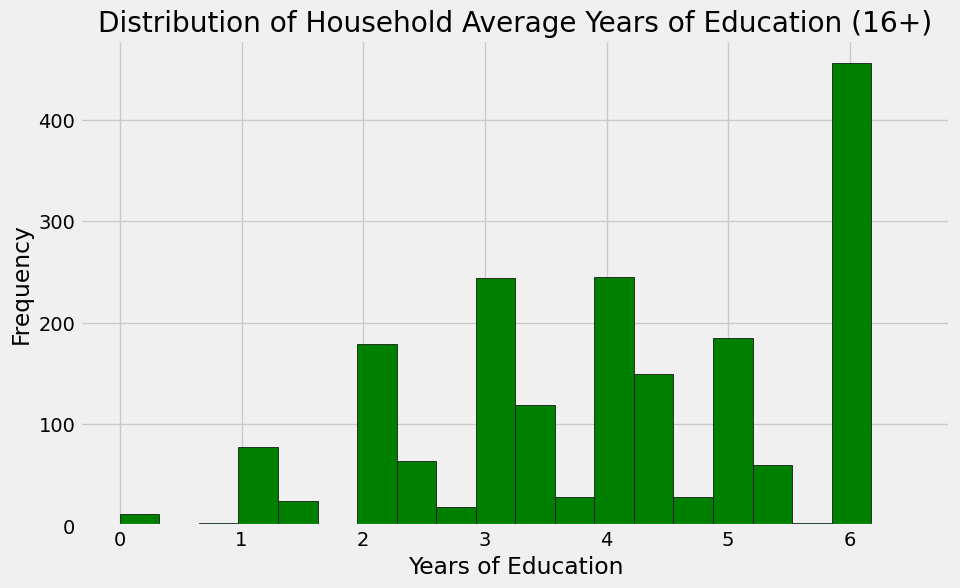

In [406]:
# visualizing the distribution of the education variable

plt.figure(figsize = (10, 6))
plt.hist(gov_data['Education'].dropna(), bins = 20, color = 'green', edgecolor = "black")
plt.title("Distribution of Household Average Years of Education (16+)")
plt.xlabel("Years of Education")
plt.ylabel("Frequency")
plt.show()

There is an observed right skewness to the Education variable, meaning there are more households with a lower average years of education as compared to a fewer number of households with higher average years of education.

Imputing the median would be a more robust measure for imputation considering it would be less sensitive to the long tail on the right side of the distrbibution.

However, the median and mean do seem to be very close which means that while there is skewness, it might not be as severe.

In [407]:
# Imputing the missing values for Education with the median

median_education = gov_data['Education'].median()

gov_data['Education'] = gov_data['Education'].fillna(median_education)

In [408]:
gov_data.pivot_table(values = 'Support',
                     index = 'Group_Key',
                     aggfunc = [np.mean, np.size],
                     margins = True)

,mean,size
,Support,Support
Group_Key,,
Control,0.727771,821
Treatment,0.846051,1127
All,0.796201,1948


In [409]:
del gov_data['Participation']

Running an Uplift Random Forest Classifier

**I am aware this isn't the best dataset for classification tasks, I just wanted to try it out while working through the causalml documentation**

In [410]:
df_train, df_test = train_test_split(gov_data, test_size = 0.2, random_state = 111)

In [411]:
df_train

,Income_Centered,Education,Age,Support,Group_Key
534,0.011084,3.500000,33.666668,1.0,Control
488,0.007330,3.000000,33.666668,1.0,Control
1516,-0.010423,5.000000,28.000000,1.0,Treatment
1251,-0.001253,3.000000,16.000000,0.0,Treatment
96,0.016033,2.000000,16.000000,0.5,Control
...,...,...,...,...,...
1299,-0.014013,3.000000,13.500000,1.0,Treatment
86,0.016442,3.000000,27.000000,0.5,Control
724,0.018140,6.000000,50.000000,0.0,Control
876,-0.010841,3.333333,32.250000,0.5,Treatment


In [412]:
clf = UpliftTreeClassifier(control_name = "Control")

In [413]:
clf.fit(df_train[['Income_Centered', 'Education', 'Age']].values, treatment = df_train['Group_Key'].values, y = df_train['Support'].values)

In [414]:
p = clf.predict(df_test[['Income_Centered', 'Education', 'Age']].values)

In [415]:
df_res = pd.DataFrame(p, columns = clf.classes_)
df_res.head()

,Control,Treatment
0,0.743697,0.836634
1,0.743697,0.836634
2,0.743697,0.836634
3,0.700831,0.853801
4,0.743697,0.836634


In [416]:
uplift_model = UpliftRandomForestClassifier(control_name = "Control")

In [417]:
uplift_model.fit(df_train[['Income_Centered', 'Education', 'Age']].values,
                 treatment = df_train['Group_Key'].values,
                 y = df_train['Support'].values)

In [418]:
df_res = uplift_model.predict(df_test[['Income_Centered', 'Education', 'Age']].values, full_output = True)

In [419]:
print(df_res.shape)

(390, 5)


In [420]:
df_res.head()

,Control,Treatment,recommended_treatment,delta_Treatment,max_delta
0,0.786884,0.820460,1,0.033576,0.033576
1,0.750070,0.856932,1,0.106861,0.106861
2,0.768912,0.828962,1,0.060050,0.060050
3,0.676570,0.897465,1,0.220895,0.220895
4,0.762146,0.815037,1,0.052892,0.052892


In [421]:
y_pred = uplift_model.predict(df_test[['Income_Centered', 'Education', 'Age']].values)

In [422]:
y_pred.shape

(390, 1)

In [423]:
# Isolating the predictions onto a dataframe for presentation
# Output of the predict func is a np array with the shape of [n_sample, n_treatment] excluding predictions for the control group

result = pd.DataFrame(y_pred, columns = uplift_model.classes_[1:])

result.head()

,Treatment
0,0.033576
1,0.106861
2,0.060050
3,0.220895
4,0.052892


In [424]:
# Creating an Uplift Curve

# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'Control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Group_Key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Group_Key'] == 'Control', 1, 0)

In [425]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]


In [426]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             support = df_test.loc[synthetic, 'Support'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

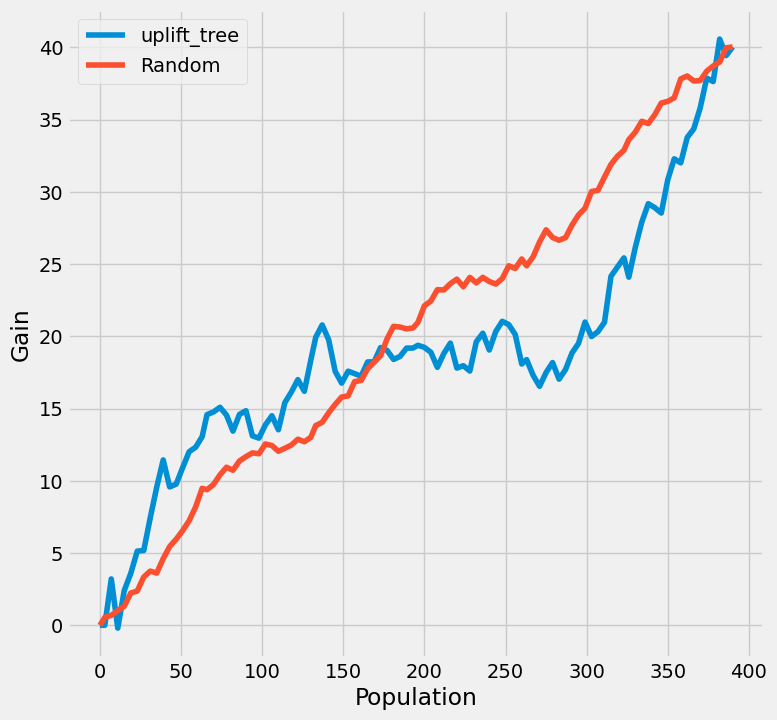

In [427]:
plot_gain(auuc_metrics, outcome_col='support', treatment_col='is_treated')


In [428]:
# Feature Importance Work

In [429]:
gov_df = pd.read_csv("https://raw.githubusercontent.com/NickCH-K/causaldata/main/Python/causaldata/gov_transfers/Government_Transfers_RDD_Data.csv")

In [430]:
gov_df['Education'] = gov_df['Education'].fillna(gov_df['Education'].median())

In [431]:
gov_df

,Income_Centered,Education,Age,Participation,Support
0,0.006571,3.5,23.666666,0,1.0
1,0.011075,1.5,42.000000,0,1.0
2,0.002424,4.0,43.000000,0,1.0
3,0.007650,6.0,21.000000,0,0.5
4,0.010001,2.0,33.000000,0,1.0
...,...,...,...,...,...
1943,-0.013489,2.0,27.333334,1,1.0
1944,-0.012106,4.5,37.000000,1,1.0
1945,-0.010159,5.0,25.857143,1,1.0
1946,-0.008668,3.0,26.000000,1,1.0


In [432]:
X = gov_df[['Income_Centered', 'Education', 'Age']]

In [433]:
treatment = gov_df['Participation']

In [434]:
y = gov_df['Support']

In [435]:
p_model = ElasticNetPropensityModel()

In [436]:
p = p_model.fit_predict(X, treatment)

In [437]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1948, number of used features: 4
[LightGBM] [Info] Start training from score 0.796201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1948, number of used features: 4
[LightGBM] [Info] Start training from score 0.796201


In [438]:
t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 3
[LightGBM] [Info] Start training from score 0.727771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [439]:
x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 821, number of used features: 3
[LightGBM] [Info] Start training from score 0.727771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [440]:
r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1948, number of used features: 3
[LightGBM] [Info] Start training from score -0.002096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1948, number of used features: 3
[LightGBM] [Info] Start training from score 0.000402


In [441]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 4s 38ms/step - loss: 104.9431 - regression_loss: 26.6818 - binary_classification_loss: 44.2037 - treatment_accuracy: 0.4950 - track_epsilon: 0.0752 - val_loss: 57.2244 - val_regression_loss: 6.3902 - val_binary_classification_loss: 30.0333 - val_treatment_accuracy: 0.9732 - val_track_epsilon: 0.0727 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 64.1488 - regression_loss: 7.7851 - binary_classification_loss: 42.6542 - treatment_accuracy: 0.5491 - track_epsilon: 0.0702 - val_loss: 72.0110 - val_regression_loss: 8.1661 - val_binary_classification_loss: 46.3357 - val_treatment_accuracy: 0.2463 - val_track_epsilon: 0.0676 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 62.8122 - regression_loss: 7.2914 - binary_classification_loss: 42.6918 - treatment_accuracy: 0.5341 - track_epsilon: 0.0654 - val_loss: 58.8960 - val_regression_loss: 4.4314 - val_binary_classificat

In [442]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [287]:
df_cumgain

,S,T,X,R,dragonnet,Random
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.250000,0.006560,0.014065,0.053309,0.250000,0.150833
2,1.000000,0.026238,0.056261,0.213235,1.000000,0.603333
3,1.500000,0.059036,0.126588,0.479779,2.250000,0.832500
4,2.000000,0.104953,0.225045,0.852941,4.000000,0.880000
...,...,...,...,...,...,...
1944,232.425495,235.795523,235.795523,234.107647,232.150495,229.605256
1945,232.809916,234.447572,234.447572,233.626653,231.622492,229.894376
1946,231.467431,233.100724,233.100724,232.281989,231.095404,229.805450
1947,230.938420,231.754975,231.754975,231.754975,229.751225,229.943459


## Feature Importance using XGBT

In [331]:
# Feature Importance - XGBT

learner_t = XGBTRegressor()


In [334]:
# Ready-to-use T-Learner using XGB
ate_t = learner_t.estimate_ate(X = gov_df[['Income_Centered', 'Education', 'Age']], treatment = gov_df['Participation'], y = gov_df['Support'])

In [335]:
print(f"Using the ready-to-use XGBT Regressor class")

print(ate_t)

Using the ready-to-use XGBT Regressor class
(array([-0.16556637]), array([-0.18195478]), array([-0.14917797]))


In [336]:
# trying the same, but by calling the base learner class and passing in XGB

learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X = gov_df[['Income_Centered', 'Education', 'Age']], treatment = gov_df['Participation'], y = gov_df['Support'])
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)


Using the BaseTRegressor class and using XGB (same result):
(array([-0.16556637]), array([-0.18195478]), array([-0.14917797]))


In [337]:
tlearner_tau = learner_t.fit_predict(gov_df[['Income_Centered', 'Education', 'Age']],
                                     gov_df['Participation'],
                                     gov_df['Support'],
                                     )

In [338]:
# Feature Importance

In [339]:
# method = auto

tlearner.get_importance(X = gov_df[['Income_Centered', 'Education', 'Age']],
                        tau = tlearner_tau,
                        normalize = True,
                        method = "auto",
                        features = ["Income_Centered", "Education", "Age"])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'Treatment': Age                0.544568
 Income_Centered    0.321561
 Education          0.133872
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

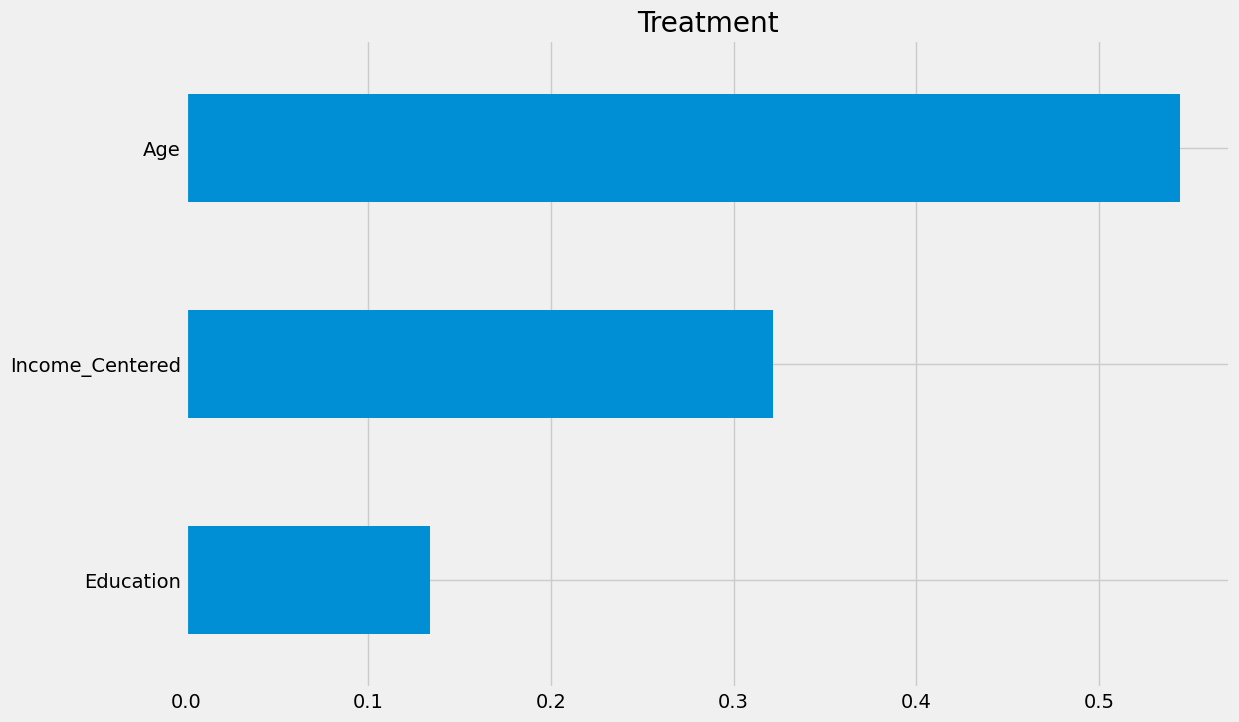

In [340]:
tlearner.plot_importance(X = gov_df[['Income_Centered', 'Education', 'Age']],
                         tau = tlearner_tau,
                         normalize = True,
                         method = "auto",
                         features = ['Income_Centered', 'Education', 'Age'])

In [341]:
# feature importance, but with method = permutation

# method = auto

tlearner.get_importance(X = gov_df[['Income_Centered', 'Education', 'Age']],
                        tau = tlearner_tau,
                        normalize = True,
                        method = "permutation",
                        features = ["Income_Centered", "Education", "Age"],
                        random_state = 42)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'Treatment': Age                0.575351
 Income_Centered    0.285237
 Education          0.170562
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

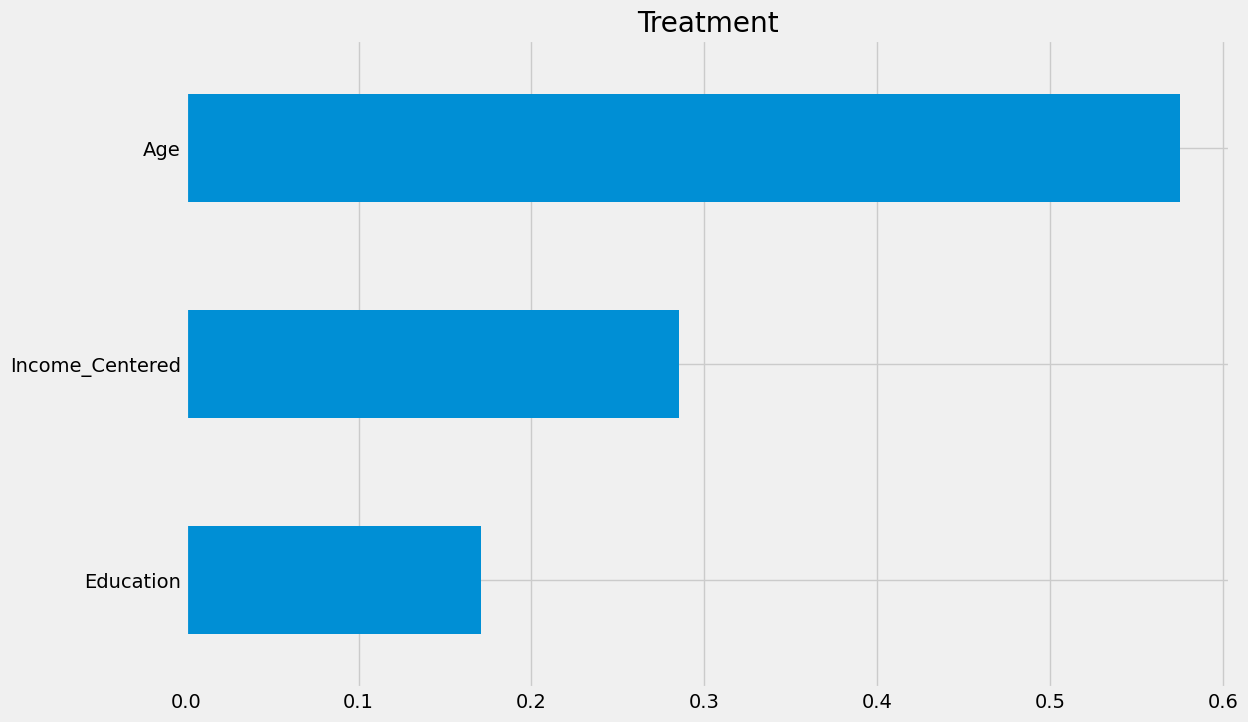

In [342]:
tlearner.plot_importance(X = gov_df[['Income_Centered', 'Education', 'Age']],
                         tau = tlearner_tau,
                         normalize = True,
                         method = "permutation",
                         features = ['Income_Centered', 'Education', 'Age'],
                         random_state = 42)

In [343]:
# feature importance, using sklearn.inspection.permutation_importance

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(gov_df[['Income_Centered', 'Education', 'Age']], tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, ['Income_Centered', 'Education', 'Age']).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 3
[LightGBM] [Info] Start training from score -0.171554
Elapsed time: 0.27721500396728516 seconds


In [344]:
pd.Series(perm_imp_test, ['Income_Centered', 'Education', 'Age']).sort_values(ascending=False)


Age                0.575351
Income_Centered    0.285237
Education          0.170562
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

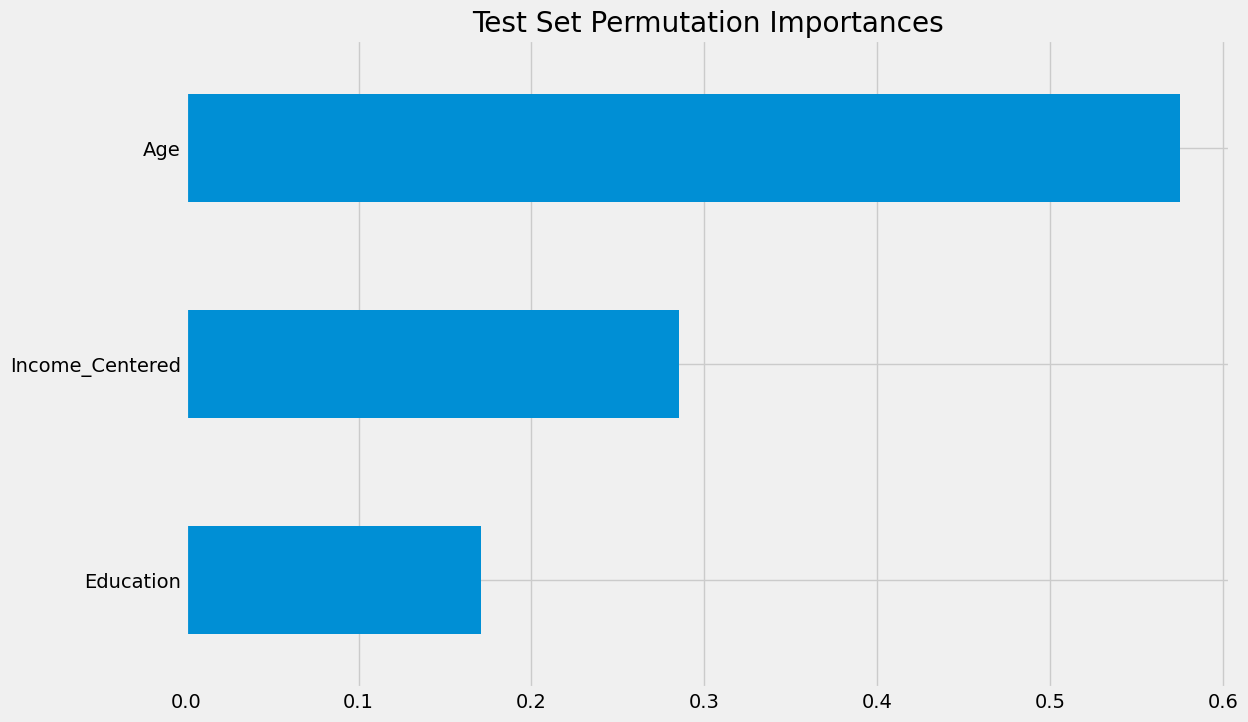

In [345]:
pd.Series(perm_imp_test, ['Income_Centered', 'Education', 'Age']).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [346]:
# Shapley Values

shap_tlearner = tlearner.get_shap_values(X= gov_df[['Income_Centered', 'Education', 'Age']],
                                         tau=tlearner_tau)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'Treatment': array([[-2.63342648e-02, -9.06579797e-02,  2.00297994e-02],
        [-1.10919181e-01, -3.50617188e-02,  1.65517236e-01],
        [-7.84166947e-02, -2.18917128e-05,  7.82775595e-02],
        ...,
        [ 9.04072782e-02,  8.34071978e-02, -7.70676622e-03],
        [ 5.62041932e-03, -7.29779447e-02, -4.01854587e-02],
        [ 1.23994419e-01,  4.48852933e-02,  1.72266179e-01]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

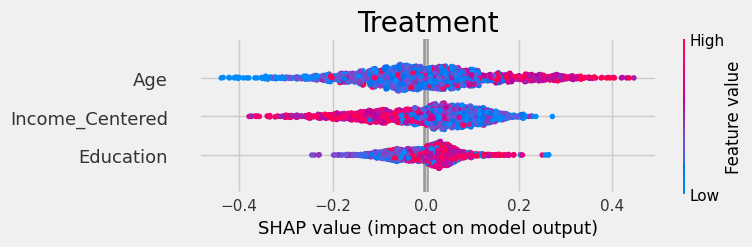

In [347]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X = gov_df[['Income_Centered', 'Education', 'Age']], tau=tlearner_tau, features = ['Income_Centered', 'Education', 'Age'])

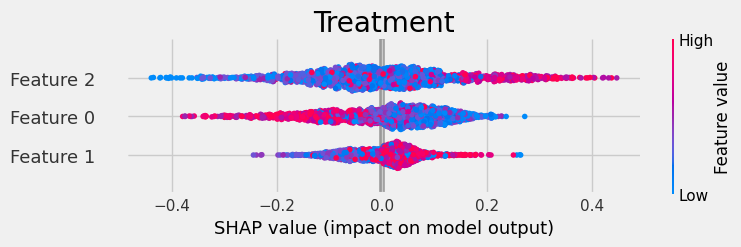

In [348]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X = gov_df[['Income_Centered', 'Education', 'Age']],
                          shap_dict=shap_tlearner)

# Feature Importance using LRS

In [358]:
# ready-to-use S-Learner using Linear Regression

In [363]:
learner_s = LRSRegressor()

In [371]:
model_tau = LGBMRegressor(importance_type = "gain")

In [364]:
ate_s = learner_s.estimate_ate( X = gov_df[['Income_Centered', 'Education', 'Age']],
                               treatment = gov_df['Participation'],
                                y = gov_df['Support'])

In [365]:
print(f"Using the ready-to-use S-Learner: ")

print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

Using the ready-to-use S-Learner: 
(array([0.09717009]), array([0.04027928]), array([0.15406091]))
ATE estimate: 0.097
ATE lower bound: 0.040
ATE upper bound: 0.154


In [366]:
learner_s_tau = learner_s.fit_predict(gov_df[['Income_Centered', 'Education', 'Age']],
                                      gov_df['Participation'],
                                      gov_df['Support'])

In [375]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(gov_df[['Income_Centered', 'Education', 'Age']], learner_s_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)


perm_imp_test = permutation_importance(
    estimator = model_tau_fit,
    X = X_test,
    y = y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, ['Income_Centered', 'Education', 'Age']).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 3
[LightGBM] [Info] Start training from score 0.097170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because the

In [376]:
pd.Series(perm_imp_test, ['Income_Centered', 'Education', 'Age']).sort_values(ascending=False)


Income_Centered    0.0
Education          0.0
Age                0.0
dtype: float64

In [377]:
shap_slearner = slearner.get_shap_values(X = gov_df[['Income_Centered', 'Education', 'Age']], tau = learner_s_tau)
shap_slearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'Treatment': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

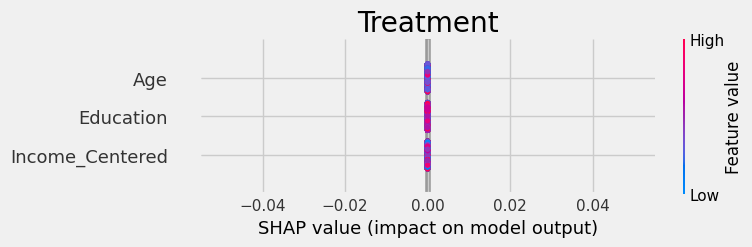

In [378]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X = gov_df[['Income_Centered', 'Education', 'Age']], tau= learner_s_tau, features=['Income_Centered', 'Education', 'Age'])